# Exploratory Data Analysis

In this notebook we'll do some exploratory data analysis over our dataset. However, since we don't have our features created yet, we cannot do much at this point. In addition, when we create them, we won't be able to extract many insights because of the nature of text-based features. For this reason, only a shallow analysis will be done at this point.

For the plots we have used `seaborn` and `altair`. `altair` is a package which allows us to plot graphics with a simple grammar as we would do in ggplot2 or Tableau. It also provides easy-to-make interactive plots. For further information please visit the project site: https://altair-viz.github.io/.

To install it, please type this command in the shell:

`! conda install -c conda-forge altair vega_datasets notebook vega`

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
alt.renderers.enable("notebook")

# Code for hiding seaborn warnings
import warnings
import nltk
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,accuracy_score

In [6]:
%matplotlib inline
# Optional in Jupyter Notebook: requires an up-to-date vega nbextension.
# alt.renderers.enable('mimetype')
alt.renderers.enable('default')
warnings.filterwarnings("ignore")
pd.set_option('display.expand_frame_repr', False)

Loading the dataset:

In [14]:
# df_path = "/home/lnc/0. Latest News Classifier/01. Dataset Creation/"
# df_path2 = df_path + 'News_dataset.csv'
newdata = pd.read_csv('New_data.csv')
df=newdata[newdata['Language']=="eng"]

In [57]:
df.iloc[5]['Text']

"Love this place for lunch! With newly added seating areas (including couches and Adirondack chairs), there are also high tables on the patio and also sheltered indoor seating, making finding a comfortable place pretty easy! The food is casual but good. There is a good beer selection.It's a great place to hit a bucket of balls (or not), relax, and enjoy lunch and a cold one!"

### Number of articles in each category

In [16]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Sentiment"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Text')),
    tooltip=[alt.Tooltip('count()', title='Number of comments'), 'Sentiment'],
    color='Category'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of sentiments in each category",
)

ValueError: Category encoding field is specified without a type; the type cannot be inferred because it does not match any column in the data.

alt.LayerChart(...)

### % of articles in each category

In [33]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Category').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='Category'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

The classes are approximately balanced. We'll first try to train the models without oversampling/undersampling. If we see some bias in the model, we'll use these techniques.

### News length by category

Definition of news length field. Although there are special characters in the text (``\r, \n``), it will be useful as an approximation.

In [28]:
df['News_length'] = df['Text'].str.len()
df['review_length'] = df['News_length']

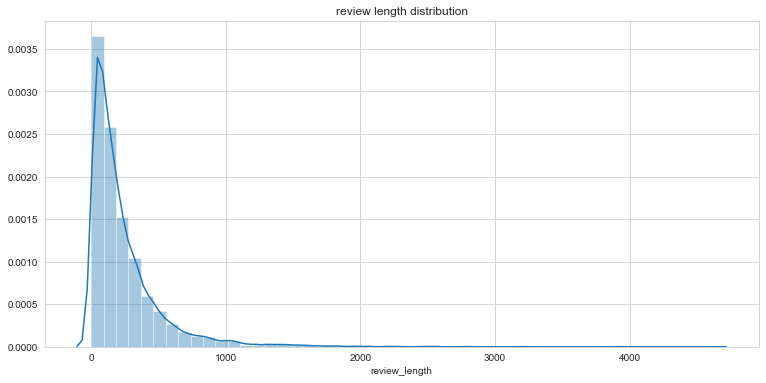

In [30]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['review_length']).set_title('review length distribution');

In [31]:
df['review_length'].describe()

count    4930.000000
mean      241.246450
std       287.222199
min         2.000000
25%        66.000000
50%       153.000000
75%       310.000000
max      4613.000000
Name: review_length, dtype: float64

Let's remove from the 95% percentile onwards to better appreciate the histogram:

In [32]:
quantile_95 = df['review_length'].quantile(0.95)
df_95 = df[df['review_length'] < quantile_95]

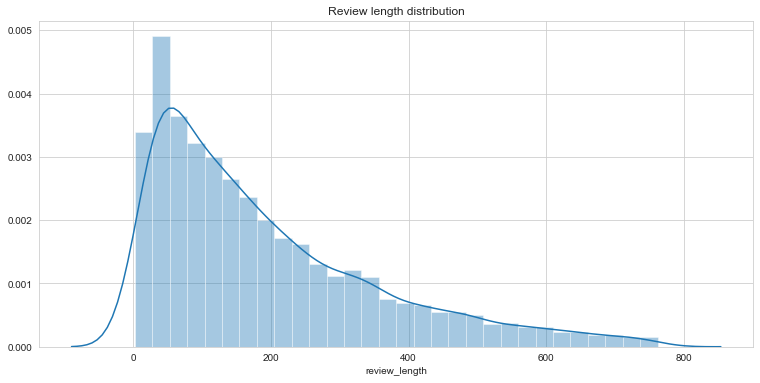

In [33]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['review_length']).set_title('Review length distribution');

We can get the number of news articles with more than 10,000 characters:

In [25]:
df_more10k = df[df['review_length'] > 10]
len(df_more10k)

0

Let's see one:

In [ ]:
df_more10k['Content'].iloc[0]

It's just a large news article.

Let's now plot a boxplot:

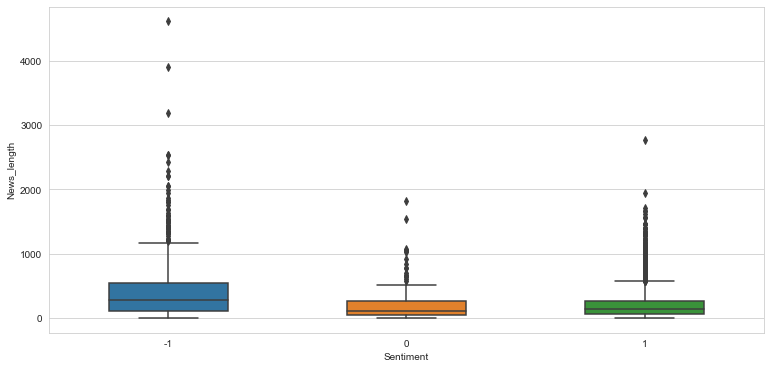

In [27]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Sentiment', y='review_length', width=.5);

Now, let's remove the larger documents for better comprehension:

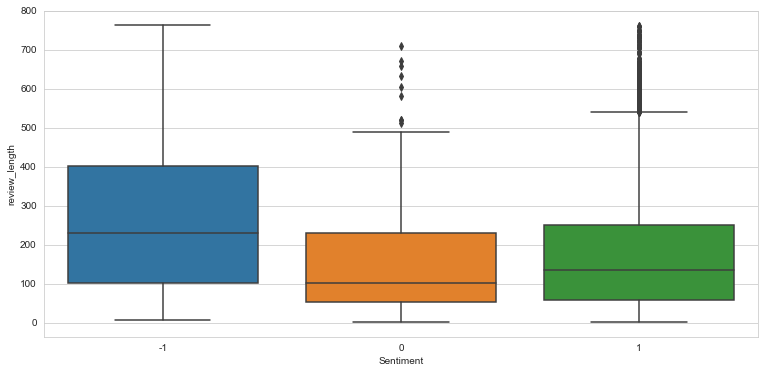

In [34]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Sentiment', y='review_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the **Feature Engineering** section.

We'll save the dataset:

In [55]:
df.iloc[1]['Text']

"I am surprised the reviews on Zomato are low, it's easily a 4+ restaurant. They have a very interesting type Indian food in tapas style with a modern twist. The portion sizes are small as with tapas. The presentation is nice and the food tasted good. I have been a few times to the place and always left happy."

# 1. Text cleaning and preparation
## 1.1. Special character cleaning
### We can see the following special characters:

* \r
* \n
* \ before possessive pronouns (government's = government\'s)
* \ before possessive pronouns 2 (Yukos' = Yukos\')
* " when quoting text

In [40]:
# \r and \n
df['Content_Parsed_1'] = df['Text'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

Regarding 3rd and 4th bullet, although it seems there is a special character, it won't affect us since it is not a real character:

In [41]:
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')

In [42]:
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()

In [43]:
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')

In [44]:
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")

## 1.5. Stemming and Lemmatization
 Since stemming can produce output words that don't exist, we'll only use a lemmatization process at this moment. Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist, so it will be more useful for us.

In [51]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


------------------------------------------------------------


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [45]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [58]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.iloc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [59]:
df['Content_Parsed_5'] = lemmatized_text_list

In [63]:
df.iloc[1]['Text']

"I am surprised the reviews on Zomato are low, it's easily a 4+ restaurant. They have a very interesting type Indian food in tapas style with a modern twist. The portion sizes are small as with tapas. The presentation is nice and the food tasted good. I have been a few times to the place and always left happy."

In [62]:
df.iloc[1]['Content_Parsed_5']

'i be surprise the review on zomato be low it easily a 4+ restaurant they have a very interest type indian food in tapas style with a modern twist the portion size be small as with tapas the presentation be nice and the food taste good i have be a few time to the place and always leave happy'

## 1.6. Stop words

In [57]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

In [ ]:

list_columns = ["Integration Type", "Language", "Sentiment", "Categories", "Text","Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [70]:
df.head()

,Integration Type,Language,Sentiment,Categories,Text,Content_Parsed
2,zomato,eng,1,food,OMG this place is really very good awesome the...,omg place really good awesome food delic...
3,zomato,eng,1,food,"I am surprised the reviews on Zomato are low, ...",surprise review zomato low easily 4+ re...
21,zomato,eng,1,experience;food;convenience;environment,Especially love their raviolis with the mushro...,especially love raviolis mushroom sauce a...
49,zomato,eng,0,experience;convenience;environment;service;value,It's located in a nice place. The restaurant h...,locate nice place restaurant nice decorat...
56,zomato,eng,-1,consistency,When you think about eating healthy and good i...,think eat healthy good nice place amélia...


## 2. Label coding
We'll create a dictionary with the label codification:

In [76]:
df.head()

,Integration Type,Language,Sentiment,Categories,Text,Content_Parsed
2,zomato,eng,1,food,OMG this place is really very good awesome the...,omg place really good awesome food delic...
3,zomato,eng,1,food,"I am surprised the reviews on Zomato are low, ...",surprise review zomato low easily 4+ re...
21,zomato,eng,1,experience;food;convenience;environment,Especially love their raviolis with the mushro...,especially love raviolis mushroom sauce a...
49,zomato,eng,0,experience;convenience;environment;service;value,It's located in a nice place. The restaurant h...,locate nice place restaurant nice decorat...
56,zomato,eng,-1,consistency,When you think about eating healthy and good i...,think eat healthy good nice place amélia...


## 3. Train - test split
We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Sentiment'], 
                                                    test_size=0.15, 
                                                    random_state=8)

## 4. Text representation

We have to define the different parameters:

* ngram_range: We want to consider both unigrams and bigrams.
* max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold
* min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
*max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the  corpus.

In [73]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [78]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(4190, 300)
(740, 300)


Please note that we have fitted and then transformed the training set, but we have only transformed the test set.

We can use the Chi squared test in order to see what unigrams and bigrams are most correlated with each category:

In [81]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most r4correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# '-1' category:
  . Most correlated unigrams:
. slow
. soon
. thank
. ok
. send
  . Most correlated bigrams:
. great food
. food service

# '0' category:
  . Most correlated unigrams:
. order
. ok
. slow
. bad
. send
  . Most correlated bigrams:
. friendly staff
. great food

# '1' category:
  . Most correlated unigrams:
. fresh
. free
. forget
. fish
. would
  . Most correlated bigrams:
. food good
. food delicious



# Support Vector Machine

In [82]:
from sklearn import svm
from pprint import pprint
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [84]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 15.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=8,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'], 'probability': [True]}, {'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree': [3, 4, 5], 'probability': [True]}, {'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf'], 'gamma': [1, 10, 100], 'probability': [True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [85]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.8033261026753434


In [86]:
best_svc = grid_search.best_estimator_

In [87]:
best_svc

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=8,
  shrinking=True, tol=0.001, verbose=False)

In [88]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=8,
  shrinking=True, tol=0.001, verbose=False)

In [89]:
svc_pred = best_svc.predict(features_test)

In [90]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.8360381861575179


In [91]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.827027027027027


In [92]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

          -1       0.89      0.46      0.61       124
           0       1.00      0.02      0.03        59
           1       0.82      0.99      0.90       557

   micro avg       0.83      0.83      0.83       740
   macro avg       0.90      0.49      0.51       740
weighted avg       0.85      0.83      0.78       740



In [93]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.836038,0.827027
